In [1]:
import numpy as np
from ss_problem import SSProblem, SecureStateReconstruct
from tests import generate_random_dtsystem_data, generate_random_io_data,solve_ssr_by_decomposition, remove_duplicate_states
from safe_control import LinearInequalityConstr
from scipy import linalg

n = 8
r = n
m = 8
p = 10
s = 5
q = 6

seed = 10
rng = np.random.default_rng(seed=seed)

# define system
dtsys_a, dtsys_b, dtsys_c, dtsys_d = generate_random_dtsystem_data(rng,n,m,p,q,is_jordan=False)

print(np.shape(dtsys_a), np.shape(dtsys_b), np.shape(dtsys_c), np.shape(dtsys_d))

# define true and fake initial states
init_state1 = rng.normal(10,2,(n,1))
init_state2 = 2*init_state1
sensor_initial_states = [init_state2 if i < s else init_state1 for i in range(p)]

# define io data
u_seq, tilde_y_his, noise_level = generate_random_io_data(dtsys_a,dtsys_b, dtsys_c, dtsys_d, s, sensor_initial_states, 
                            rng, has_u_seq = True, is_noisy = False)

# construct a problem instance and a solution instance
ss_problem = SSProblem(dtsys_a, dtsys_b, dtsys_c, dtsys_d, tilde_y_his, 
                        attack_sensor_count=s,input_sequence=u_seq,measurement_noise_level= noise_level )
# ssr_solution = SecureStateReconstruct(ss_problem,possible_comb=comb1)
ssr_solution = SecureStateReconstruct(ss_problem)

# solve for sparse observability index (soi) and eigenvalue observability index (eoi) 
soi = SecureStateReconstruct.compute_sparse_observability(ss_problem.A,ss_problem.C)
eoi = SecureStateReconstruct.compute_eigenvalue_observability(ss_problem.A,ss_problem.C)
print(f'The problem have a sparse observability index {soi}, eigenvalue observability index: {eoi}, attacked sensor count: {s}')

# solve ssr by brute-force approach
possible_states_bruteforce,corresp_sensors, _ = ssr_solution.solve_initial_state(error_bound = 1e-3)
possible_states_bruteforce = remove_duplicate_states(possible_states_bruteforce.transpose())
# solve ssr by decomposition
possible_states_decomposition = solve_ssr_by_decomposition(ssr_solution, eoi,is_composed=True)

# printing
print('-----------------------  brute-force   approach  -------------------------------')
print( possible_states_bruteforce)
    

print('-----------------------  decomposition approach  -------------------------------')
print(possible_states_decomposition)


(8, 8) (8, 8) (10, 8) (10, 8)
The problem have a sparse observability index 6, eigenvalue observability index: 6, attacked sensor count: 5
-----------------------  brute-force   approach  -------------------------------
[array([19.21204265, 22.4891393 , 15.1362587 , 23.96036498, 24.39759349,
       22.57774026, 27.45634156, 15.55923604]), array([ 9.60602132, 11.24456965,  7.56812935, 11.98018249, 12.19879674,
       11.28887013, 13.72817078,  7.77961802])]
-----------------------  decomposition approach  -------------------------------
[array([19.21204265, 22.4891393 , 15.1362587 , 23.96036498, 24.39759349,
       22.57774026, 27.45634156, 15.55923604]), array([ 9.60602132, 11.24456965,  7.56812935, 11.98018249, 12.19879674,
       11.28887013, 13.72817078,  7.77961802])]


(8, 8) (8, 8) (8, 8) (8, 8)
The problem have a sparse observability index 6, eigenvalue observability index: 6, attacked sensor count: 5
-----------------------  brute-force   approach  -------------------------------
[array([15.93347445, 23.82264365, 24.37396945, 18.29171298, 18.06585929,
       20.78466719, 15.12514049, 21.17867207]), array([ 7.96673723, 11.91132183, 12.18698472,  9.14585649,  9.03292964,
       10.3923336 ,  7.56257025, 10.58933604])]
-----------------------  decomposition approach  -------------------------------
[array([15.93347445, 23.82264365, 24.37396945, 18.29171298, 18.06585929,
       20.78466719, 15.12514049, 21.17867207]), array([ 7.96673723, 11.91132183, 12.18698472,  9.14585649,  9.03292964,
       10.3923336 ,  7.56257025, 10.58933604])]
(8, 8) (8, 8) (9, 8) (9, 8)
The problem have a sparse observability index 6, eigenvalue observability index: 6, attacked sensor count: 5
-----------------------  brute-force   approach  -------------------------------
[

<Figure size 1000x800 with 0 Axes>

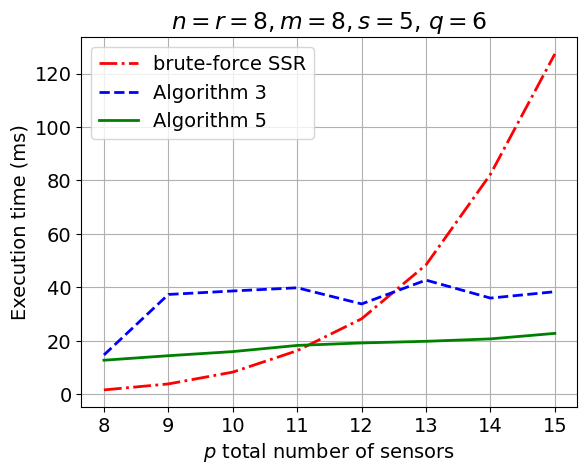

In [3]:
# Figure 1(a): Runtime comparison between different approaches with varying p
import timeit
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def runtime_compare_varying_p():
    n = 8
    r = n
    m = 8
    # p = 10
    s = 5
    q = 6

    # bf_and_decomp_ssr(n,r,m,p,s,q)

    # p_range = range(8,16)
    p_range = range(8,10)
    seed = None

    p_list, exe_time_decomp_m, exe_time_decomp, exe_time_bf = [], [], [],[]
    for p in p_range:
        seed = 1
        rng = np.random.default_rng(seed=seed)

        # define system
        dtsys_a, dtsys_b, dtsys_c, dtsys_d = generate_random_dtsystem_data(rng,n,m,p,q,is_jordan=False)

        print(np.shape(dtsys_a), np.shape(dtsys_b), np.shape(dtsys_c), np.shape(dtsys_d))

        # define true and fake initial states
        init_state1 = rng.normal(10,2,(n,1))
        init_state2 = 2*init_state1
        sensor_initial_states = [init_state2 if i < s else init_state1 for i in range(p)]

        # define io data
        u_seq, tilde_y_his, noise_level = generate_random_io_data(dtsys_a,dtsys_b, dtsys_c, dtsys_d, s, sensor_initial_states, 
                                    rng, has_u_seq = True, is_noisy = False)

        # construct a problem instance and a solution instance
        ss_problem = SSProblem(dtsys_a, dtsys_b, dtsys_c, dtsys_d, tilde_y_his, 
                                attack_sensor_count=s,input_sequence=u_seq,measurement_noise_level= noise_level )
        # ssr_solution = SecureStateReconstruct(ss_problem,possible_comb=comb1)
        ssr_solution = SecureStateReconstruct(ss_problem)

        # solve for sparse observability index (soi) and eigenvalue observability index (eoi) 
        soi = SecureStateReconstruct.compute_sparse_observability(ss_problem.A,ss_problem.C)
        eoi = SecureStateReconstruct.compute_eigenvalue_observability(ss_problem.A,ss_problem.C)
        print(f'The problem have a sparse observability index {soi}, eigenvalue observability index: {eoi}, attacked sensor count: {s}')

        # solve ssr by brute-force approach
        possible_states_bruteforce,corresp_sensors, _ = ssr_solution.solve_initial_state(error_bound = 1e-3)
        possible_states_bruteforce = remove_duplicate_states(possible_states_bruteforce.transpose())
        # solve ssr by decomposition
        possible_states_decomposition = solve_ssr_by_decomposition(ssr_solution, eoi,is_composed=True)

        # printing
        print('-----------------------  brute-force   approach  -------------------------------')
        print( possible_states_bruteforce)
            

        print('-----------------------  decomposition approach  -------------------------------')
        print(possible_states_decomposition)
        
        # time it, tqking avarage over 100 computations
        execution_time_decomposition = timeit.timeit(lambda : solve_ssr_by_decomposition(ssr_solution, eoi), number=100)
        execution_time_decomposition_m = timeit.timeit(lambda : solve_ssr_by_decomposition(ssr_solution, eoi,is_composed=False), number=100)

        execution_time_bruteforce = timeit.timeit(lambda : ssr_solution.solve_initial_state(error_bound=1e-3), number=100)
        
        time_decomp = execution_time_decomposition*1000/100
        time_decomp_m = execution_time_decomposition_m*1000/100
        time_bf = execution_time_bruteforce*1000/100

        p_list.append(p)
        exe_time_decomp_m.append(time_decomp_m)
        exe_time_decomp.append(time_decomp)
        exe_time_bf.append(time_bf)

    # Adjust font size and paper size (figure size)
    plt.figure(figsize=(10, 8))  # Set figure size (width, height in inches)
    plt.rcParams.update({'font.size': 14})  # Globally set the font size

    # plotting
    fig, ax = plt.subplots()
    ax.plot(np.array(p_list), np.array(exe_time_bf),label = 'brute-force SSR',color='red',linestyle='-.',linewidth=2)
    ax.plot(np.array(p_list), np.array(exe_time_decomp),label = 'Algorithm 3',color='blue',linestyle='--',linewidth=2)
    ax.plot(np.array(p_list), np.array(exe_time_decomp_m),label = 'Algorithm 5',color='green',linestyle='-',linewidth=2)


    ax.set(xlabel='$p$ total number of sensors', ylabel='Execution time (ms)',
        title=rf'$n = r = {n}, m  = {m}, s = {s}$, $ q = {q}$')
    ax.grid()

    # Add a legend
    ax.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    fig.savefig("figures/timing_for_ssr_algorithms_varying_p.pdf")
    # Show the plot
    plt.show()

runtime_compare_varying_p()

(4, 4) (4, 4) (12, 4) (12, 4)
The problem have a sparse observability index 6, eigenvalue observability index: 6, attacked sensor count: 5
-----------------------  brute-force   approach  -------------------------------
[array([11.21019497,  9.48686219,  8.67128733,  8.52525391])]
-----------------------  decomposition approach  -------------------------------
[array([11.21019497,  9.48686219,  8.67128733,  8.52525391])]
(5, 5) (5, 5) (12, 5) (12, 5)
The problem have a sparse observability index 6, eigenvalue observability index: 6, attacked sensor count: 5
-----------------------  brute-force   approach  -------------------------------
[array([ 9.64804447, 10.15359973, 13.08460822, 10.36736708, 10.55266762])]
-----------------------  decomposition approach  -------------------------------
[array([ 9.64804447, 10.15359973, 13.08460822, 10.36736708, 10.55266762])]


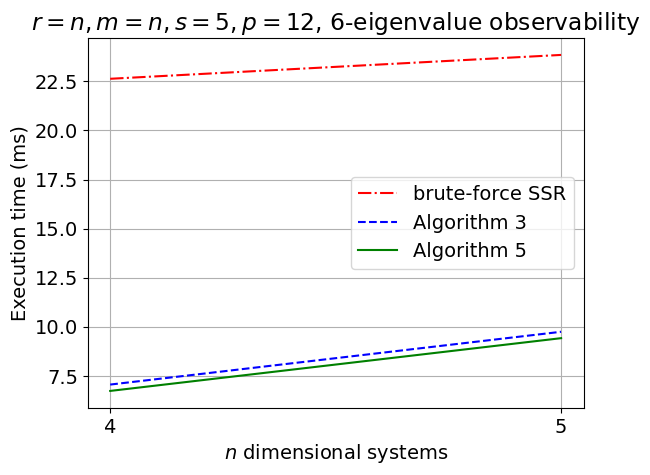

In [5]:
# Figure 1(b): Runtime comparison between different approaches with varying n

import timeit
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def runtime_compare_varying_n():
    n = 8
    r = n
    m = 8
    p = 12
    s = 5
    q = 6

    # bf_and_decomp_ssr(n,r,m,p,s,q)

    # n_range = range(4,10)
    n_range = range(4,6)
    seed = None


    m_list, exe_time_decomp_m, exe_time_decomp, exe_time_bf = [], [], [],[]
    for n in n_range:
        r = n
        m = n
        seed = 10
        rng = np.random.default_rng(seed=seed)

        # define system
        dtsys_a, dtsys_b, dtsys_c, dtsys_d = generate_random_dtsystem_data(rng,n,m,p,q,is_jordan=False)

        print(np.shape(dtsys_a), np.shape(dtsys_b), np.shape(dtsys_c), np.shape(dtsys_d))

        # define true and fake initial states
        init_state1 = rng.normal(10,2,(n,1))
        init_state2 = 2*init_state1
        sensor_initial_states = [init_state2 if i < s else init_state1 for i in range(p)]

        # define io data
        u_seq, tilde_y_his, noise_level = generate_random_io_data(dtsys_a,dtsys_b, dtsys_c, dtsys_d, s, sensor_initial_states, 
                                    rng, has_u_seq = True, is_noisy = False)

        # construct a problem instance and a solution instance
        ss_problem = SSProblem(dtsys_a, dtsys_b, dtsys_c, dtsys_d, tilde_y_his, 
                                attack_sensor_count=s,input_sequence=u_seq,measurement_noise_level= noise_level )
        # ssr_solution = SecureStateReconstruct(ss_problem,possible_comb=comb1)
        ssr_solution = SecureStateReconstruct(ss_problem)

        # solve for sparse observability index (soi) and eigenvalue observability index (eoi) 
        soi = SecureStateReconstruct.compute_sparse_observability(ss_problem.A,ss_problem.C)
        eoi = SecureStateReconstruct.compute_eigenvalue_observability(ss_problem.A,ss_problem.C)
        print(f'The problem have a sparse observability index {soi}, eigenvalue observability index: {eoi}, attacked sensor count: {s}')

        # solve ssr by brute-force approach
        possible_states_bruteforce,corresp_sensors, _ = ssr_solution.solve_initial_state(error_bound = 1e-3)
        possible_states_bruteforce = remove_duplicate_states(possible_states_bruteforce.transpose())
        # solve ssr by decomposition
        possible_states_decomposition = solve_ssr_by_decomposition(ssr_solution, eoi,is_composed=True)

        # printing
        print('-----------------------  brute-force   approach  -------------------------------')
        print( possible_states_bruteforce)
            

        print('-----------------------  decomposition approach  -------------------------------')
        print(possible_states_decomposition)
        
        # time it, tqking avarage over 100 computations
        execution_time_decomposition = timeit.timeit(lambda : solve_ssr_by_decomposition(ssr_solution, eoi), number=100)
        execution_time_decomposition_m = timeit.timeit(lambda : solve_ssr_by_decomposition(ssr_solution, eoi,is_composed=False), number=100)

        execution_time_bruteforce = timeit.timeit(lambda : ssr_solution.solve_initial_state(error_bound=1e-3), number=100)
        
        time_decomp = execution_time_decomposition*1000/100
        time_decomp_m = execution_time_decomposition_m*1000/100
        time_bf = execution_time_bruteforce*1000/100

        m_list.append(m)
        exe_time_decomp_m.append(time_decomp_m)
        exe_time_decomp.append(time_decomp)
        exe_time_bf.append(time_bf)

    # plotting
    fig, ax = plt.subplots()
    ax.plot(np.array(m_list), np.array(exe_time_bf),label = 'brute-force SSR',color='red',linestyle='-.')
    ax.plot(np.array(m_list), np.array(exe_time_decomp),label = 'Algorithm 3',color='blue',linestyle='--')
    ax.plot(np.array(m_list), np.array(exe_time_decomp_m),label = 'Algorithm 5',color='green',linestyle='-')


    ax.set(xlabel='$n$ dimensional systems', ylabel='Execution time (ms)',
        title=rf'$ r = n, m = n, s = {s}, p = {p}$, $ {q}$-eigenvalue observability ')
    ax.grid()

    # Add a legend
    ax.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    fig.savefig("figures/timing_for_ssr_algorithms_varying_n.pdf")
    # Show the plot
    plt.show()

runtime_compare_varying_n()

In [26]:
# one-step control
from safe_control import SafeProblem

def solve_safe_control_by_brute_force(ssr_solution:SecureStateReconstruct, safe_prob:SafeProblem, u_nom):
     # solve ssr by brute-force
    possible_states,corresp_sensors, _ = ssr_solution.solve(error_bound = 1e-3)
    possible_states = possible_states.transpose() # now possible_states[0] is one possible state
    possible_states = remove_duplicate_states(possible_states)

    u_safe1,lic1,flag1 = safe_prob.cal_safe_control(u_nom,possible_states)
    return u_safe1

def solve_safe_control_by_decomposition(ssr_solution:SecureStateReconstruct, safe_prob:SafeProblem, u_nom, eoi):
    # solve ssr by decomposition
    possible_states_subssr= solve_ssr_by_decomposition(ssr_solution, eoi,is_initial_state=False)
    u_safe2,lic2,flag2 = safe_prob.cal_safe_control(u_nom,possible_states_subssr)

    return u_safe2



def solve_safe_control_woSSR(ssr_solution, safe_prob, u_nom, eoi):
    initial_substates_subssr = solve_ssr_by_decomposition(ssr_solution, eoi, is_print = True,is_composed= False)
    # print(f'initial_substates_subssr: {initial_substates_subssr}')
    lic3 = safe_prob.cal_safe_input_constr_woSSR(initial_substates_subssr)
    u_safe3,flag3 = safe_prob.cal_safe_qp(u_nom,lic3)

    return u_safe3

# system setting
n = 8
r = n
m = 8
p = 10
s = 5
q = 6

seed = 10
rng = np.random.default_rng(seed=seed)

# define system
dtsys_a, dtsys_b, dtsys_c, dtsys_d = generate_random_dtsystem_data(rng,n,m,p,q,is_jordan=False)

print(np.shape(dtsys_a), np.shape(dtsys_b), np.shape(dtsys_c), np.shape(dtsys_d))

# define true and fake initial states
init_state1 = rng.normal(10,2,(n,1))
init_state2 = 2*init_state1
sensor_initial_states = [init_state2 if i < s else init_state1 for i in range(p)]

# define io data
u_seq, tilde_y_his, noise_level = generate_random_io_data(dtsys_a,dtsys_b, dtsys_c, dtsys_d, s, sensor_initial_states, 
                            rng, has_u_seq = True, is_noisy = False)

# construct a problem instance and a solution instance
ss_problem = SSProblem(dtsys_a, dtsys_b, dtsys_c, dtsys_d, tilde_y_his, 
                        attack_sensor_count=s,input_sequence=u_seq,measurement_noise_level= noise_level )
# ssr_solution = SecureStateReconstruct(ss_problem,possible_comb=comb1)
ssr_solution = SecureStateReconstruct(ss_problem)

# solve for sparse observability index (soi) and eigenvalue observability index (eoi) 
soi = SecureStateReconstruct.compute_sparse_observability(ss_problem.A,ss_problem.C)
eoi = SecureStateReconstruct.compute_eigenvalue_observability(ss_problem.A,ss_problem.C)
print(f'The problem have a sparse observability index {soi}, eigenvalue observability index: {eoi}, attacked sensor count: {s}')


# define CBF and solve safe control
h = np.vstack([np.identity(n),-np.identity(n)])
q = 40*np.ones((2*n,1))
gamma = 0.8
u_nom = np.random.normal(0,3,(m,1))
# print(f'u_nom: {u_nom}')
safe_prob = SafeProblem(ssr_solution.problem,h,q,gamma)

execution_time_bruteforce = timeit.timeit(lambda : solve_safe_control_by_brute_force(ssr_solution, safe_prob, u_nom), number=10)
execution_time_decomposition = timeit.timeit(lambda : solve_safe_control_by_decomposition(ssr_solution, safe_prob, u_nom, eoi), number=10)
execution_time_woSSR = timeit.timeit(lambda : solve_safe_control_woSSR(ssr_solution, safe_prob, u_nom, eoi), number=10)


print(f'execution time: bruteforce - {execution_time_bruteforce}, decom - {execution_time_decomposition}, alg5 - {execution_time_woSSR}')



(8, 8) (8, 8) (10, 8) (10, 8)
The problem have a sparse observability index 6, eigenvalue observability index: 6, attacked sensor count: 5
execution time: bruteforce - 0.14249625800039212, decom - 0.4066832609996709, alg5 - 0.1670839110001907


In [9]:
################# closed-loop system case ####################
from safe_control import SafeProblem
import random

def solve_safe_control_by_brute_force(ssr_solution:SecureStateReconstruct, safe_prob:SafeProblem, u_nom):
     # solve ssr by brute-force
    possible_states,corresp_sensors, _ = ssr_solution.solve(error_bound = 1e-3)
    possible_states = possible_states.transpose() # now possible_states[0] is one possible state
    possible_states = remove_duplicate_states(possible_states)

    u_safe1,lic1,flag1 = safe_prob.cal_safe_control(u_nom,possible_states)
    return u_safe1

def solve_safe_control_by_decomposition(ssr_solution:SecureStateReconstruct, safe_prob:SafeProblem, u_nom, eoi):
    # solve ssr by decomposition
    possible_states_subssr= solve_ssr_by_decomposition(ssr_solution, eoi,is_initial_state=False)
    u_safe2,lic2,flag2 = safe_prob.cal_safe_control(u_nom,possible_states_subssr)

    return u_safe2



def solve_safe_control_woSSR(ssr_solution, safe_prob, u_nom, eoi):
    initial_substates_subssr = solve_ssr_by_decomposition(ssr_solution, eoi, is_print = True,is_composed= False)
    # print(f'initial_substates_subssr: {initial_substates_subssr}')
    lic3 = safe_prob.cal_safe_input_constr_woSSR(initial_substates_subssr)
    u_safe3,flag3 = safe_prob.cal_safe_qp(u_nom,lic3)

    return u_safe3

# system setting

n = 4
r = 4
m = 4

p = 10
s = 5
q = 8

seed = 10
rng = np.random.default_rng(seed=seed)

dtsys_a = np.array([[0.7, 0.1, 0.1, 0.1],
              [-0.1, 1.1, -0.1, 0.1],
              [0.1, 0.1, 0.9, -0.1],
              [0.2, 0.2, -0.2, 0.80]])

dtsys_b = np.identity(n)

# to compute possible C
dtsys_c = np.random.normal(1,1,(p,n))

unique_eig_vals, generalized_space,_,_ = SecureStateReconstruct.compute_sys_eigenproperty(dtsys_a)
# print(f'unique_eig_vals:{unique_eig_vals}')
# print(f'generalized_space: {generalized_space}')
generalized_space = [np.real(space) for space in generalized_space]

unobs_subspace_per_sensor = [[] for _ in range(p)]
for j in range(r):
    # choose p - (q+1) sensors from p sensors for subspace j
    # these sensors do not observe subspace j
    unobs_sensor_subspace_j = np.random.choice(np.arange(0, p), p-(q+1), replace=False)
    for i in range(p):
        if i in unobs_sensor_subspace_j:
            unobs_subspace_per_sensor[i].append(j)

for i in range(p):
    ci = dtsys_c[i:i+1,:]
    ci_tranpose = ci.transpose()
    # each sensor has its own unobservable subspace
    unobs_space_ind = unobs_subspace_per_sensor[i]
    # check if the ubobservable space is empty
    if unobs_space_ind:
        basis_matrix_unobs = np.hstack([ generalized_space[j] for j in  unobs_space_ind])
        bmu_transpose = basis_matrix_unobs.transpose()
        proj_ci_transpose = basis_matrix_unobs @ np.linalg.inv(bmu_transpose @ basis_matrix_unobs) @ bmu_transpose @ ci_tranpose
        ci_remain =  ci_tranpose - proj_ci_transpose
        dtsys_c[i:i+1,:] = ci_remain.transpose()



dtsys_d = np.zeros((p,m))

# generate io_data
# attack random sensors
x_true = np.ones((n,1))
x_fake1 = -np.ones((n,1))
x_fake2 = 2*np.ones((n,1))
sensor_to_inital_state_index= [0]*5 + [1]*2 + [2]*3
random.shuffle(sensor_to_inital_state_index)
sensor_initial_states = [ x_true if i == 0 else x_fake1 if i == 1 else x_fake2 for i in sensor_to_inital_state_index]
print(f'sensor_to_inital_state_index: {sensor_to_inital_state_index}')


u_seq, tilde_y_his, noise_level = generate_random_io_data(dtsys_a,dtsys_b, dtsys_c, dtsys_d, s, sensor_initial_states, 
                            rng, has_u_seq = True, is_noisy = False)



# construct a problem instance and a solution instance
ss_problem = SSProblem(dtsys_a, dtsys_b, dtsys_c, dtsys_d, tilde_y_his, 
                        attack_sensor_count=s,input_sequence=u_seq,measurement_noise_level= noise_level )
# ssr_solution = SecureStateReconstruct(ss_problem,possible_comb=comb1)
ssr_solution = SecureStateReconstruct(ss_problem)

# solve for sparse observability index (soi) and eigenvalue observability index (eoi) 
soi = SecureStateReconstruct.compute_sparse_observability(ss_problem.A,ss_problem.C)
eoi = SecureStateReconstruct.compute_eigenvalue_observability(ss_problem.A,ss_problem.C)
print(f'The problem have a sparse observability index {soi}, eigenvalue observability index: {eoi}, attacked sensor count: {s}')


# define CBF and solve for safe control
h = np.vstack([np.identity(n),-np.identity(n)])
q = 40*np.ones((2*n,1))
gamma = 0.8
u_nom = np.random.normal(0,3,(m,1))

# print(f'u_nom: {u_nom}')
safe_prob = SafeProblem(ssr_solution.problem,h,q,gamma)


## one-step safe control
usafe1 = solve_safe_control_by_brute_force(ssr_solution, safe_prob, u_nom)
usafe2 = solve_safe_control_by_decomposition(ssr_solution, safe_prob, u_nom,eoi)
usafe3 = solve_safe_control_woSSR(ssr_solution, safe_prob, u_nom,eoi)
print(u_nom,usafe1,usafe2,usafe3)

one_step_flag = True

sensor_to_inital_state_index: [2, 2, 0, 1, 1, 0, 0, 0, 0, 2]
The problem have a sparse observability index 8, eigenvalue observability index: 8, attacked sensor count: 5
[[-2.59970143]
 [-0.83274372]
 [-5.75367471]
 [ 2.75955686]] [-2.59970131 -0.83274354 -5.75367438  2.75955679] [-2.59970131 -0.83274354 -5.75367438  2.75955679] [-2.59970133 -0.83274355 -5.75367441  2.75955676]


In [10]:
print(u_seq)
print(tilde_y_his)

[[-0.31722222  1.89147627 -2.72642573  0.19588341]
 [ 0.1798113  -4.4989311   2.56686678 -1.26755372]
 [-1.22659086 -3.54661709 -1.81228201  1.99221434]
 [ 0.          0.          0.          0.        ]]
[[ 2.91528484e+00 -1.69313324e+00  9.76657189e-01 -4.70784306e+00
  -4.95401877e+00  4.18159524e+00  3.99771375e+00  3.32976074e+00
   1.11022302e-15  2.21817137e+00]
 [ 2.20129298e+00 -4.14403497e+00 -8.92730833e-01 -3.38589806e+00
  -9.84947973e+00  7.17464263e-01  4.44595527e-01 -3.72119119e+00
  -9.16987963e-01 -3.07673204e+00]
 [ 3.39099828e+00  6.03496597e-01  2.00372924e-01 -8.42493972e+00
  -5.91877720e+00  2.70044756e+00  5.26800885e+00  3.84674285e+00
   4.20044553e-01  1.69800641e+00]
 [ 2.45245287e+00  4.27489169e+00 -4.68978155e+00 -1.76957006e+01
  -1.03089324e+01 -2.47393263e+00  8.76783482e+00 -4.51098136e+00
   2.33434539e+00 -3.41978602e+00]]


In [7]:
## closed-loop system 
assert one_step_flag,'run one step safe control cell first!'
import math

total_step = 100
dt = 0.1

def get_u_nom(step):
    u_nom = np.array([[math.sin(dt*step)],
                      [math.cos(dt*step)],
                      [-math.sin(dt*step)],
                      [-math.cos(dt*step)]])
    return u_nom

x_tr_lst, x_fk1_lst,x_fk2_lst, u_lst, cost_lst = [],[],[],[],[]

# latest u from two-stage
u_lastest = solve_safe_control_by_brute_force(ssr_solution, safe_prob, u_nom)
# y_latest = dtsys_c@x
for tau in range(n,n+total_step):
    # update u_seq
    u_seq = u_seq[1:,:] # remove the oldest input
    u_seq[:-1, :] = u_lastest # add the lastest input
    u_seq = np.vstack([u_seq, np.zeros((1,m))]) # add a row of all zeros

    # update tilde_y_his

    # compute new ssr_solution

    # get u_nom

    # solve for next control

    # logging

# plot trajectory, input sequence, and cost

NameError: name 'tilde_y_his_new' is not defined

In [1]:
from tests import main_secure_and_safe_control
main_secure_and_safe_control()

S&S problem has 4 states, 4 inputs, 7 sensors, 4 attacked sensors.
The problem have a sparse observability index 6, eigenvalue observability index: 6, attacked sensor count: 4
No possible state found for sub-ssr problem. Consider relax the voting range bound
sorted_states: {0: []}
states_to_vote_list:[]
-------------solving subspace state x0 fails---------------

 -----------------------  brute-force   approach  -------------------------------
possible_states:[array([ 7.57464665, 13.9584895 , 28.30282311, 40.14130862]), array([ 8.19799794, 16.06483306, 32.39735453, 46.26823812])]
u_safe: [  3.02719107  -3.49068982 -11.53971134 -23.85891806]
||u_safe - u_nom||:30.765233263973773

 -----------------------  decomposition approach  -------------------------------


/home/xiao/safety-under-sensor-attacks/ss_problem.py:983: ComplexWarning: Casting complex values to real discards the imaginary part
  full_space.astype(np.float128)
/home/xiao/safety-under-sensor-attacks/ss_problem.py:1003: ComplexWarning: Casting complex values to real discards the imaginary part
  proj_mat.astype(np.float64)
/home/xiao/safety-under-sensor-attacks/ss_problem.py:226: ComplexWarning: Casting complex values to real discards the imaginary part
  obser_matrix_array[:,:,i:i+1] = obser_i.reshape(ss_problem.io_length,ss_problem.n,1)


TypeError: 'NoneType' object is not iterable

In [4]:
from tests import main_secure_and_safe_control_timing
main_secure_and_safe_control_timing(n = 8, m = 4, p_range=range(6,16))

TypeError: initialization() missing 1 required positional argument: 'seed'

In [ ]:
import numpy as np
import control as ct

Ac = np.array([[0,1],[0,0]])
Bc = np.array([[0],[1]])
Cc = np.zeros((1,2))
Dc = np.zeros((1,1))
ts = 0.1

sys = ct.ss(Ac, Bc, Cc, Dc)
discrete_sys = sys.sample(ts,method = 'zoh')
print([discrete_sys.A, discrete_sys.B, discrete_sys.C, discrete_sys.D])

In [ ]:
from sympy import *
p, v, u = symbols('p v u')
init_printing(use_unicode=True,use_latex=True)

h2 = 10 - p*p
p_plus = p - 0.1*v + 0.005*u
h2_plus = h2.subs(p,p_plus)

expand(h2_plus - h2 + 0.1*h2)
# latex(expand(h2_plus - h2 + 0.1*h2))

In [ ]:
import numpy as np
from ss_problem import SSProblem, SecureStateReconstruct
from tests import generate_random_dtsystem_data, generate_random_io_data,solve_ssr_by_decomposition, remove_duplicate_states
from safe_control import LinearInequalityConstr
from scipy import linalg

def test1():
    n = 5
    m = 3
    p = 5
    s = 3

    # seed = 10
    rng = np.random.default_rng()
    eig_vals = 1.0*rng.random((n,))+0.1 # eig value in [-1.1,-0.1] and [0.1,1.1]
    eig_vals = np.multiply(np.sign(rng.random((n,)) - 1.0/2),eig_vals)

    jordan_eig = np.diag(eig_vals)
    r = p

    # make the matrix jordan
    jordan_eig[0,1] = 1
    jordan_eig[1,1] = jordan_eig[0,0]
    r = p - 1

    trial = 0
    while True: 
        P = rng.random((n, n))
        for i in range(n):
            pi = P[:,i:i+1]
            pi_nom = pi / (np.linalg.norm(pi) + 1e-10)
            P[:,i:i+1] = pi_nom
        try:
            trial = trial + 1
            Pinv = np.linalg.pinv(P)
            P_det = np.linalg.det(P)
            if P_det < 0.1:
                raise np.linalg.LinAlgError
            # print(f'total trials for getting dtsys_A: {trial}')
            break
        except np.linalg.LinAlgError:
            pass

    dtsys_a = P@jordan_eig@Pinv

    dtsys_b = np.identity(n)
    dtsys_c = np.random.normal(1,1,(p,n))

    unique_eig_vals, generalized_space,_,_ = SecureStateReconstruct.compute_sys_eigenproperty(dtsys_a)

    print(unique_eig_vals)
    print(generalized_space)

    q = 2
    # dtsys_b = np.random.normal(1,1,(n,m))
    dtsys_b = np.identity(n)
    dtsys_c = np.random.normal(1,1,(p,n))

    unobs_subspace_per_sensor = [[] for _ in range(p)]
    for j in range(r):
        # choose p - (q+1) sensors from p sensors for subspace j
        # these sensors do not observe subspace j
        unobs_sensor_subspace_j = np.random.choice(np.arange(0, p), p-(q+1), replace=False)
        for i in range(p):
            if i in unobs_sensor_subspace_j:
                unobs_subspace_per_sensor[i].append(j)

    print(f'unobs_subspace_per_sensor={unobs_subspace_per_sensor}')
    for i in range(p):
        print(f'i={i}')
        ci = dtsys_c[i:i+1,:]
        ci_tranpose = ci.transpose()
        print(ci_tranpose)
        # each sensor has its own unobservable subspace
        unobs_space_ind = unobs_subspace_per_sensor[i]
        if unobs_space_ind:
            basis_matrix_unobs = np.hstack([ generalized_space[j] for j in  unobs_space_ind])
            bmu_transpose = basis_matrix_unobs.transpose()
            print(f'bmu_transpose= {bmu_transpose}')
            np.linalg.inv(bmu_transpose @ basis_matrix_unobs)
            print(np.shape(bmu_transpose))
            print(np.shape(ci))
            print(np.shape(ci_tranpose))
            bmu_transpose @ ci_tranpose
            # np.linalg.inv(bmu_transpose @ basis_matrix_unobs) 
            proj_ci_transpose = basis_matrix_unobs @ np.linalg.inv(bmu_transpose @ basis_matrix_unobs) @ bmu_transpose @ ci_tranpose
            ci_remain =  ci_tranpose - proj_ci_transpose
            dtsys_c[i:i+1,:] = ci_remain.transpose()

for i in range(100):
    rng = np.random.default_rng()
    try:
        # test1()
        generate_random_dtsystem_data(rng,is_jordan = True)
    except:
        pass


In [ ]:
rng = np.random.default_rng()
dtsys_a,dtsys_b, dtsys_c, dtsys_d = generate_random_dtsystem_data(rng,is_jordan = True)


In [ ]:
selected_sensor_subspace_j = np.random.choice(np.arange(1, p+1), p, replace=False)
selected_sensor_subspace_j

In [ ]:
np.linalg.norm(D[:,1])

In [ ]:
import numpy as np
from ss_problem import SSProblem, SecureStateReconstruct
from tests import generate_random_dtsystem_data, generate_random_io_data,solve_ssr_by_decomposition, remove_duplicate_states
from safe_control import LinearInequalityConstr
from scipy import linalg

n = 8
m = 8
p = 10
s = 4
q = 6

seed = 100
rng = np.random.default_rng(seed=seed)

# define system
dtsys_a, dtsys_b, dtsys_c, dtsys_d = generate_random_dtsystem_data(rng,n,m,p,q)

print(np.shape(dtsys_a), np.shape(dtsys_b), np.shape(dtsys_c), np.shape(dtsys_d))

In [ ]:
import numpy as np

# Create a 3x1 matrix (one-column matrix)
A = np.array([[1],
              [2],
              [3]])

# Delete the last (and only) column (index 0)
A = np.delete(A, 0, axis=1)

if A.size >0:
    print('a')
else:
    print('b')